# 1. Set up the notebook

## 1.1 Import modules

In [9]:
import numpy as np
import sympy as sym
import json
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.interpolate import interp1d
from IPython.display import display, IFrame, HTML

## 1.2 Define data loaders

Here is a function to load data from hardware (and resample it at 100 Hz using linear interpolation).

In [10]:
def load_hardware_data(filename, t_min_offset=0, t_max_offset=0):
    # load raw data
    with open(filename, 'r') as f:
        data = json.load(f)

    # convert lists to numpy arrays
    for val in data.values():
        for key in val.keys():
            val[key] = np.array(val[key])

    # create an array of times at which to subsample
    t_min = -np.inf
    t_max = np.inf
    for key, val in data.items():
        t_min = max(t_min, val['time'][0])
        t_max = min(t_max, val['time'][-1])
    t_min += t_min_offset * 1000
    t_max -= t_max_offset * 1000
    nt = int(1 + np.floor((t_max - t_min) / 10.))
    t = np.arange(0, 10 * nt, 10) / 1000.
    resampled_data = {'time': t}

    # resample raw data with linear interpolation
    for k, v in data.items():
        f = interp1d((v['time'] - t_min) / 1000., v['data'])
        resampled_data[k] = f(t)
        
    # return the resampled data
    return resampled_data

Text(0.5, 0, 'Time (s)')

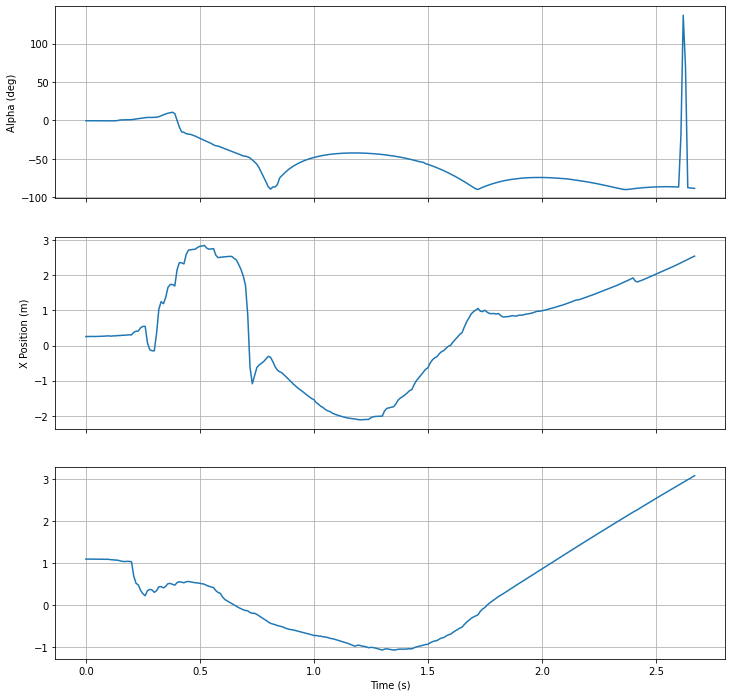

In [29]:
data = load_hardware_data(
    'FlightData/Flight_4.json', # <-- replace with name of file with hardware data
    t_min_offset=3.7,      # <-- (optional) replace with how many seconds of data to ignore at start
    t_max_offset=19,      # <-- (optional) replace with how many seconds of data to ignore at end
)


t = data['time']
alpha = data['ae483log.alpha']
ox = data['ae483log.o_x']
oz = data['ae483log.o_z']

fig, (angle, x_pos, z_pos) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)


angle.plot(t, np.degrees(alpha))
angle.grid()

angle.set_ylabel('Alpha (deg)')

x_pos.plot(t, ox)
x_pos.grid()
x_pos.set_ylabel('X Position (m)')

z_pos.plot(t, oz)
z_pos.grid()
z_pos.set_xlabel("Time (s)")
z_pos.set_ylabel("Z Position (m)")
